In [6]:
from skimage import data

from skimage import transform
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
import skimage
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import math

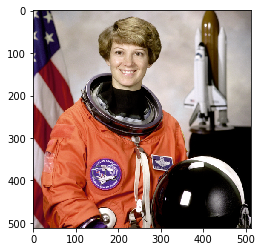

In [7]:
img1 = data.astronaut()
plt.imshow(img1)
plt.show()

In [8]:
img1 = rgb2gray(data.astronaut())
img2 = transform.rotate(img1, 180)
tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                                  translation=(0, -200))
img3 = transform.warp(img1, tform)

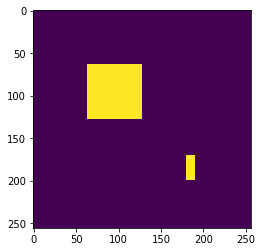

In [9]:
square = np.zeros((256,256))
square[64:128,64:128] = 1

square[170:200,180:190] = 1
plt.imshow(square)
plt.show()
square1 = square + np.random.randn(256,256)/20
square2 = square1[::-1,::-1]

# ORB Example

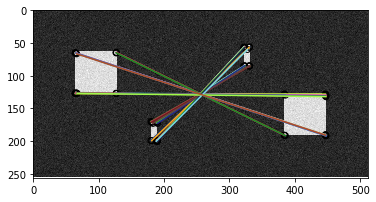

In [282]:
descriptor_extractor = ORB(n_keypoints=32)

descriptor_extractor.detect_and_extract(square1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(square2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors


matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
fig, ax = plt.subplots()
plt.gray()
plot_matches(ax, square1, square2, keypoints1, keypoints2, matches12)
plt.show()

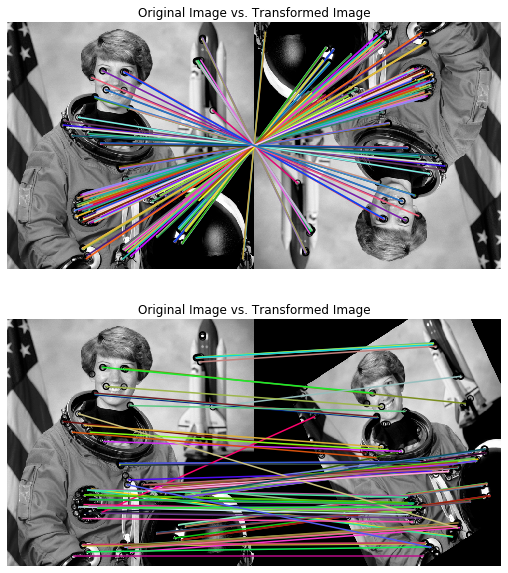

In [274]:
descriptor_extractor = ORB(n_keypoints=256)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10,10))

plt.gray()

plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
ax[0].axis('off')
ax[0].set_title("Original Image vs. Transformed Image")

plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
ax[1].axis('off')
ax[1].set_title("Original Image vs. Transformed Image")


plt.show()

# Oriented FAST

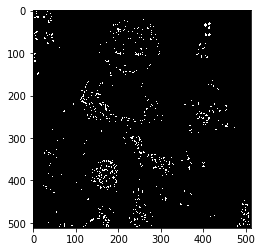

5271


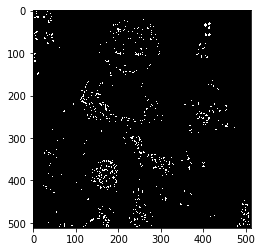

5271
[5.33883529 3.93208078 4.61097412 ... 3.61973333 3.25594824 2.88897961]


In [81]:
from skimage.feature import corner_fast, corner_harris
import numpy as np

plt.imshow(corner_fast(img1, n=9, threshold=0.1) > 0)
plt.show()
print(np.sum(corner_fast(img1, n=9, threshold=0.1) > 0))

plt.imshow((corner_fast(img2, n=9, threshold=0.1) > 0)[::-1,::-1])
plt.show()
print(np.sum(corner_fast(img2, n=9, threshold=0.1) > 0))
print(corner_fast(img2, n=9, threshold=0.1)[corner_fast(img2, n=9, threshold=0.1) > 0])

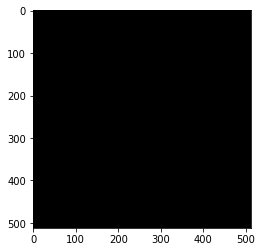

In [83]:
plt.imshow((corner_fast(img2, n=9, threshold=0.1) > 0)[::-1,::-1].astype(int) - (corner_fast(img1, n=9, threshold=0.1) > 0).astype(int))
plt.show()

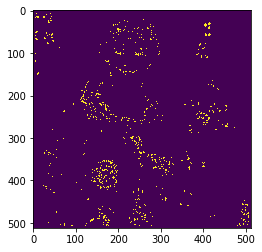

In [10]:
bresenham_circle = np.array([[-3,0], [-3,1],  [-2,2],  [-1,3],
                              [0,3],  [1,3],   [2,2],   [3,1],
                              [3,0],  [3,-1],  [2,-2],  [1,-3],
                              [0,-3], [-1,-3], [-2,-2], [-3,-1]])
harris_k = 0.04 

@njit
def get_FAST(img, n = 9, threshold = 0.15):
    width = img.shape[0]
    height = img.shape[1]
    result = []
    
    for i in range(4,width-4):
        for j in range(4,height-4):
            corner = eval_FAST9(img, i, j, n, threshold)
            if corner == 1:
                result.append([i,j])
                
            
    return np.array(result)
            
@njit
def eval_FAST9(img, x0, y0, n, threshold):
    first_value = 0
    first_count = 0
    first_track = True
    
    current_count = 0
    current_value = 0
    
    for i in range(16):
        x,y = bresenham_circle[i]
        x,y = x+x0, y+y0
        dif = check_thresh(img[x0,y0], img[x,y], threshold)
        if i == 0:
            if dif == 0: first_track = False
            else:
                first_count = 1
                current_count = 1
                first_value = dif
                current_value = dif
        else:
            if dif == 0:
                current_count = 0
                current_value = 0  
                first_track = False
            elif dif != current_value:
                current_count = 1
                current_value = dif
                first_track = False
            elif dif == current_value:
                current_count = current_count + 1
                if first_track: first_count = first_count + 1
            
                
        if i == 15 and first_value == current_value: current_count = current_count + first_count
            
        if current_count >= n:
            return 1
        
    return 0  
    
@njit
def check_thresh(baseline, value, threshold):
    if   baseline - value > threshold:
        return -1
    elif value - baseline > threshold:
        return  1
    else:
        return 0

@njit
def harris_value(img, w_size, x0, y0):
    Ix = get_Ix(img, w_size, x0, y0)
    Iy = get_Iy(img, w_size, x0, y0)
    
    Ix2 = np.sum(Ix * Ix)
    Iy2 = np.sum(Iy * Iy)
    Ixy = np.sum(Ix * Iy)
    
    det = Ix2 * Iy2 - Ixy * Ixy
    trace = Ix2 + Iy2
    
    return det - harris_k * (trace ** 2)
    
@njit 
def get_Ix(img, w_size, x0, y0):
    result = np.zeros((2*w_size+1, 2*w_size+1))
    x0 = x0 - w_size
    y0 = y0 - w_size
    for i in range(2*w_size+1):
        for j in range(2*w_size+1):
            x,y = x0 + i, y0 + j
            result[i,j] = ((img[x+1,y] - img[x-1,y])/2) ** 2
    return result

@njit 
def get_Iy(img, w_size, x0, y0):
    result = np.zeros((2*w_size+1, 2*w_size+1))
    x0 = x0 - w_size
    y0 = y0 - w_size
    for i in range(2*w_size+1):
        for j in range(2*w_size+1):
            x,y = x0 + i, y0 + j
            result[i,j] = ((img[x,y+1] - img[x,y-1])/2) ** 2
    return result

@njit
def nFAST9(img, n, threshold):
    fast_points = get_FAST(img, n = 9, threshold = threshold)
    harris_vals = []
    npoints = fast_points.shape[0]
    for i in range(npoints):
        x,y = fast_points[i,0], fast_points[i,1]
        harris_vals.append(harris_value(img, 3, x, y))
    harris_vals = np.array(harris_vals)
    filtered = np.argsort(harris_vals)[::-1][:n]
    points = fast_points[filtered,:]
    return points

@njit
def list_to_arr(points, width = 512, height = 512):
    arr = np.zeros((width, height))
    length = points.shape[0]
    for i in range(length):
        x,y = points[i,0], points[i,1]
        arr[x,y] = 1
    return arr

points = get_FAST(img1, threshold = 0.10)
plt.imshow(list_to_arr(points))
plt.show()

In [ ]:
points = nFAST9(img1, n = 256, threshold = 0.3)
plt.imshow(list_to_arr(points))
plt.show()
points2 = nFAST9(img2, n = 256, threshold = 0.3)
plt.imshow(list_to_arr(points2)[::-1,::-1])
plt.show()
print(len(points2))
# Test Symmetry
plt.imshow((list_to_arr(points2)[::-1,::-1] - list_to_arr(points)) != 0)
plt.show()
print(np.mean((list_to_arr(points2)[::-1,::-1] - list_to_arr(points)) != 0).astype(int))
points = get_FAST(img1, threshold = 0.10)
points2 = get_FAST(img2, threshold = 0.10)
plt.imshow(list_to_arr(points) - list_to_arr(points2)[::-1,::-1])
plt.show()
print(np.mean((list_to_arr(points2)[::-1,::-1] - list_to_arr(points)) != 0).astype(int))

In [11]:
@njit
def m10(img,x0,y0):
    total = 0
    x0 = x0
    y0 = y0
    for i in range(7):
        for j in range(7):
            x = i-3
            y = j-3
            if x**2 + y**2 <= 9: total = total + x * (img[x+x0,y+y0])
    return total

@njit
def m01(img,x0,y0):
    total = 0
    x0 = x0
    y0 = y0
    for i in range(7):
        for j in range(7):
            x = i-3
            y = j-3
            if x**2 + y**2 <= 9: total = total + y * (img[x+x0,y+y0])
    return total

@njit
def m00(img,x0,y0):
    total = 0
    x0 = x0
    y0 = y0
    for i in range(7):
        for j in range(7):
            x = i-3
            y = j-3
            if x**2 + y**2 <= 9: total = total + (img[x+x0,y+y0])
    return total

@njit
def get_orientation(img, x0, y0):
    return math.atan2(m01(img,x0,y0),m10(img,x0,y0))

@njit
def get_centroid(img, x0, y0):
    return m10(img,x0,y0)/m00(img,x0,y0) , m01(img,x0,y0)/m00(img,x0,y0)

@njit
def oFast(img, n = 256, threshold = 0.25):
    points = nFAST9(img, n, threshold)
    length = points.shape[0]
    orientations = []
    for i in range(length):
        x,y = points[i,0], points[i,1]
        orientations.append(get_orientation(img, x, y))
    return points, np.array(orientations)

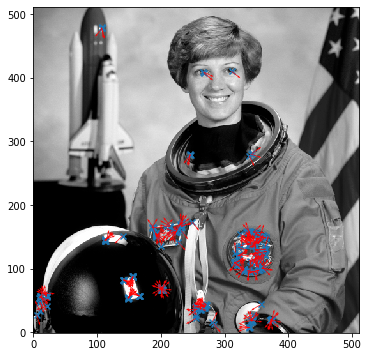

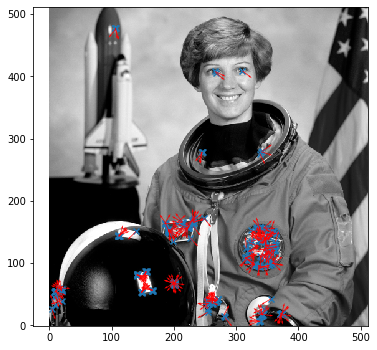

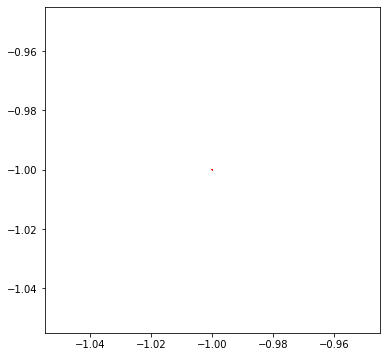

In [199]:
points, orientations = oFast(img1, n = 256, threshold = 0.3)
plt.figure(figsize=(6,6))
plt.imshow(img1[::-1,::-1], origin = 0)
plt.scatter(512-points[:,1], 512-points[:,0], marker = 'x')
plt.quiver(512-points[:,1], 512-points[:,0], -np.sin(orientations), -np.cos(orientations), color = 'r', width = 0.002, angles = 'xy')
plt.show()

points2, orientations2 = oFast(img2, n = 256, threshold = 0.3)
plt.figure(figsize=(6,6))
plt.imshow(img2, origin = 0)
plt.scatter(points2[:,1], points2[:,0], marker = 'x')
plt.quiver(points2[:,1], points2[:,0], np.sin(orientations2), np.cos(orientations2), color = 'r', width = 0.002, angles = 'xy')
plt.show()

plt.figure(figsize=(6,6))
# plt.scatter(points2[:,1] - (512-points[:,1]), points2[:,0] - (512-points[:,0]), marker = 'x')
plt.quiver(points2[:,1] - (512-points[:,1]), points2[:,0] - (512-points[:,0]), 
           np.sin(orientations2) + np.sin(orientations), np.cos(orientations2) + np.cos(orientations), 
           color = 'r', width = 0.002, angles='xy', scale_units='xy', scale=1)
plt.show()

# points, orientations = oFast(square, n = 100, threshold = 0.1)
# plt.figure(figsize=(8,8))
# plt.imshow(np.abs(square[::-1,::-1]-1), origin = 0)
# plt.scatter(256-points[:,1], 256-points[:,0], marker = 'x')
# plt.quiver(256-points[:,1], 256-points[:,0], -np.sin(orientations), -np.cos(orientations), color = 'r', width = 0.002)
# plt.show()

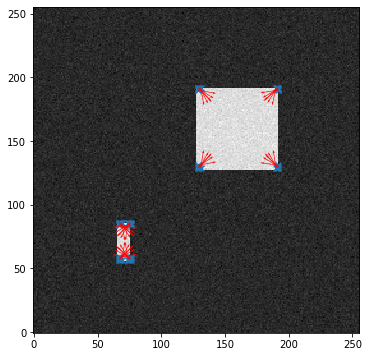

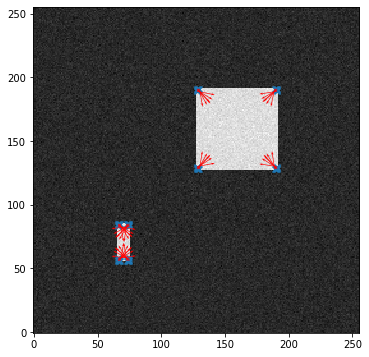

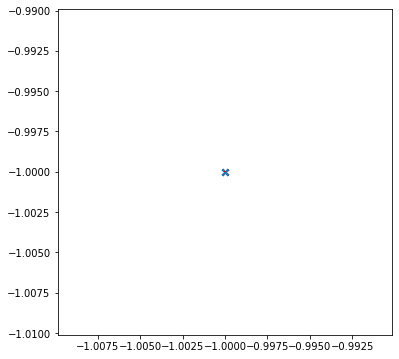

In [214]:
points, orientations = oFast(square1, n = 256, threshold = 0.3)
plt.figure(figsize=(6,6))
plt.imshow(square1[::-1,::-1], origin = 0)
plt.scatter(256-points[:,1], 256-points[:,0], marker = 'x')
plt.quiver(256-points[:,1], 256-points[:,0], -np.sin(orientations), -np.cos(orientations), color = 'r', width = 0.002, angles = 'xy')
plt.show()

points2, orientations2 = oFast(square2, n = 256, threshold = 0.3)
plt.figure(figsize=(6,6))
plt.imshow(square2, origin = 0)
plt.scatter(points2[:,1], points2[:,0], marker = 'x')
plt.quiver(points2[:,1], points2[:,0], np.sin(orientations2), np.cos(orientations2), color = 'r', width = 0.002, angles = 'xy')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(points2[:,1] - (256 - points[:,1]), points2[:,0] - (256 - points[:,0]), marker = 'x')
plt.quiver(points2[:,1] - (256-points[:,1]), points2[:,0] - (256-points[:,0]), 
           np.sin(orientations2) + np.sin(orientations), np.cos(orientations2) + np.cos(orientations), 
           color = 'r', width = 0.002, angles='xy', scale_units='xy', scale=1)
plt.show()

# Rotation-Aware BRIEF

**ROTATIONS CAN BE SPED UP VIA LOOKUP TABLE**

In [79]:
def generate_BRIEF_pairs(patch_radius, dim, window_radius):
    window_size = 2*window_radius + 1
    tests = set()
    while len(tests) < dim:
        pairs = np.random.randint(low = 0, high = patch_radius*2 + 1, size = 4)
        pairs1 = (pairs[0],pairs[1],pairs[2],pairs[3])
        pairs2 = (pairs[2],pairs[3],pairs[0],pairs[1])
        if abs(pairs[0] - pairs[2]) < window_size or abs(pairs[1] - pairs[3]) < window_size: continue
        if pairs1 in tests or pairs2 in tests: continue
        tests.add(pairs1)
    return np.array([list(test) for test in tests])

@njit
def create_integral(img):
    width, height = img.shape[0], img.shape[1]
    result = np.zeros((width, height))
    for i in range(width):
        for j in range(height):
            if i == 0:
                if j == 0:
                    result[0,0] = img[0,0]
                else:
                    result[0,j] = img[0,j] + result[0,j-1]
            else:
                if j == 0:
                    result[i,j] = img[i,j] + result[i-1, j]
                else:
                    result[i,j] = img[i,j] + result[i-1, j] + result[i,j-1] - result[i-1, j-1]              
    return result

@njit
def create_smoothed(integral, window_radius = 5):
    width, height = integral.shape[0], integral.shape[1]
    result = np.zeros((width, height))
    for i in range(width):
        for j in range(height):
            ll_x, ll_y = max(0, i-window_radius),         max(0, j-window_radius)
            ul_x, ul_y = max(0, i-window_radius),         min(height-1, j + window_radius)
            lr_x, lr_y = min(width-1, i + window_radius), max(0, j-window_radius)
            ur_x, ur_y = min(width-1, i + window_radius), min(height-1, j + window_radius)
            lli = integral[ll_x, ll_y]
            uli = integral[ul_x, ul_y]
            lri = integral[lr_x, lr_y]
            uri = integral[ur_x, ur_y]
            intensity_sum = lli + uri - uli - lri
            result[i,j] = intensity_sum / ((ur_x - ll_x) * (ur_y - ll_y))
    return result    

@njit
def rotate_pairs(pairs, theta):
    pairs_t = (pairs - BRIEF_PATCH_RADIUS).T
    r_theta = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta),  np.cos(theta)]], dtype = np.float64)    
    rotated1 = r_theta @ pairs_t[:2,:].astype(np.float64)
    rotated2 = r_theta @ pairs_t[2:,:].astype(np.float64)
    rotated = np.concatenate((rotated1, rotated2), axis = 0)
    
    rounded = np.zeros(rotated.shape)
    rounded = np.round_(rotated, 0, rounded)
    rounded = rounded.astype(np.int64)
    
    return rounded.T 

generate_BRIEF_pairs(15, 16, 2).T

array([[17,  5, 29, 29, 23,  0, 26,  1,  1,  9,  3, 26, 10, 23, 21,  4],
       [ 1,  0, 22, 15, 19, 20,  4,  8,  7, 29,  2,  9, 11,  6, 15,  0],
       [28, 24,  4,  0,  7, 20,  2, 12,  6, 22, 10, 18, 30, 16,  9, 10],
       [13, 25,  3, 25, 10,  8, 13, 17,  0, 20, 15, 19, 19, 22, 29,  8]])

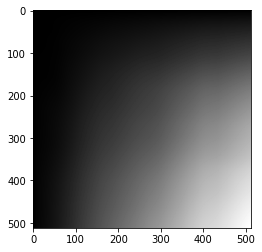

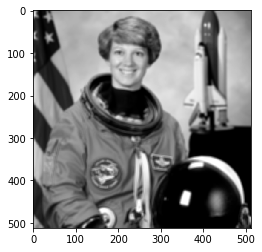

In [344]:
integral = create_integral(img1)
plt.imshow(integral)
plt.show()

smoothed = create_smoothed(integral, window_radius = 3)
plt.imshow(smoothed)
plt.show()

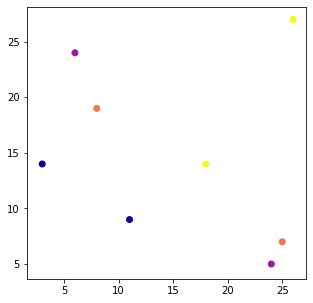

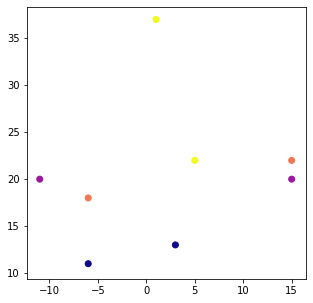

In [342]:
BRIEF_PAIRS = generate_BRIEF_pairs(BRIEF_PATCH_RADIUS, 4, BRIEF_WINDOW_RADIUS)

plt.figure(figsize=(5,5))
plt.scatter(BRIEF_PAIRS[:,0], BRIEF_PAIRS[:,1], c = np.linspace(0,1,4), cmap = 'plasma')
plt.scatter(BRIEF_PAIRS[:,2], BRIEF_PAIRS[:,3], c = np.linspace(0,1,4), cmap = 'plasma')
plt.show()

Rotated = rotate_pairs(BRIEF_PAIRS, np.pi/4)
plt.figure(figsize=(5,5))
plt.scatter(Rotated[:,0], Rotated[:,1], c = np.linspace(0,1,4), cmap = 'plasma')
plt.scatter(Rotated[:,2], Rotated[:,3], c = np.linspace(0,1,4), cmap = 'plasma')
plt.show()

In [128]:
BRIEF_PATCH_RADIUS = 15
BRIEF_WINDOW_RADIUS = 2
BRIEF_DIM = 512
BRIEF_PAIRS = generate_BRIEF_pairs(BRIEF_PATCH_RADIUS, BRIEF_DIM, BRIEF_WINDOW_RADIUS)
    
@njit
def compute_brief(img, pairs, x0, y0):
    x0 = x0 
    y0 = y0 
    results = []
    for i in range(BRIEF_DIM):
        x1, y1 = x0 + pairs[i,0], y0 + pairs[i,1]
        x2, y2 = x0 + pairs[i,2], y0 + pairs[i,3]
        results.append(int(img[x1,y1] > img[x2,y2]))
    return np.array(results)

@njit
def rBRIEF(img, points, orientations, pairs):
    npoints = points.shape[0]
    results = np.zeros((1,BRIEF_DIM))
#     smoothed = create_smoothed(create_integral(square1), BRIEF_WINDOW_RADIUS)
    for i in range(npoints):
        brief = rBRIEF_one(img, points[i,0], points[i,1], orientations[i], pairs).reshape(1,-1)
        results = np.concatenate((results, brief), axis = 0)
    return results[1:,:]

@njit
def rBRIEF_one(img, x, y, orientation, pairs):
    rotated = rotate_pairs(pairs, orientation)
    return compute_brief(img, rotated, x, y)

In [123]:
points, orientations = oFast(square1, n = 32, threshold = 0.3)
points2, orientations2 = oFast(square2, n = 32, threshold = 0.3)

point1, orientation1 = points[0], orientations[0]
x1,y1 = point1
point2, orientation2 = points2[0], orientations2[0]
x2,y2 = point2
point1, orientation1, point2, orientation2

rotated1 = rotate_pairs(BRIEF_PAIRS, orientation1) 
rotated2 = rotate_pairs(BRIEF_PAIRS, orientation2)

# plt.figure(figsize=(5,5))
# plt.scatter(BRIEF_PAIRS[:,0]-BRIEF_PATCH_RADIUS, BRIEF_PAIRS[:,1]-BRIEF_PATCH_RADIUS)
# plt.scatter(BRIEF_PAIRS[:,2]-BRIEF_PATCH_RADIUS, BRIEF_PAIRS[:,3]-BRIEF_PATCH_RADIUS)
# plt.show()
# plt.figure(figsize=(5,5))
# plt.scatter(rotated1[:,0], rotated1[:,1])
# plt.scatter(rotated1[:,2], rotated1[:,3])
# plt.show()
# plt.figure(figsize=(5,5))
# plt.scatter(rotated2[:,0], rotated2[:,1])
# plt.scatter(rotated2[:,2], rotated2[:,3])
# plt.show()

# smoothed1 = create_smoothed(create_integral(square1), 2)
# smoothed2 = create_smoothed(create_integral(square2), 2)
# plt.imshow(smoothed1, origin = 0)
# plt.scatter(y1,x1, marker = 'x', c = 'r')
# plt.show()
# plt.imshow(smoothed2, origin = 0)
# plt.scatter(y2,x2, marker = 'x', c = 'r')
# plt.show()
# plt.figure(figsize=(5,5))
# plt.imshow(smoothed1[y1-BRIEF_PATCH_RADIUS:y1 +BRIEF_PATCH_RADIUS+1,x1-BRIEF_PATCH_RADIUS:x1 +BRIEF_PATCH_RADIUS+1], origin = 0)
# plt.scatter(rotated1[:,0]+BRIEF_PATCH_RADIUS, rotated1[:,1]+BRIEF_PATCH_RADIUS, c = np.linspace(0,1,len(rotated1[:,1])), cmap ='Oranges')
# plt.scatter(rotated1[:,2]+BRIEF_PATCH_RADIUS, rotated1[:,3]+BRIEF_PATCH_RADIUS, c = np.linspace(0,1,len(rotated1[:,1])), cmap ='Oranges')
# plt.show()
# plt.figure(figsize=(5,5))
# plt.imshow(smoothed2[y2-BRIEF_PATCH_RADIUS:y2 +BRIEF_PATCH_RADIUS+1,x2-BRIEF_PATCH_RADIUS:x2 +BRIEF_PATCH_RADIUS+1], origin = 0)
# plt.scatter(rotated2[:,0]+BRIEF_PATCH_RADIUS, rotated2[:,1]+BRIEF_PATCH_RADIUS, c = np.linspace(0,1,len(rotated1[:,1])), cmap ='Oranges')
# plt.scatter(rotated2[:,2]+BRIEF_PATCH_RADIUS, rotated2[:,3]+BRIEF_PATCH_RADIUS, c = np.linspace(0,1,len(rotated1[:,1])), cmap ='Oranges')
# plt.show()

# print(compute_brief(smoothed1, rotated1, x1, y1))
# print(compute_brief(smoothed2, rotated2, x2, y2))

# b1 = rBRIEF_one(smoothed1, point1[0], point1[1], orientation1, BRIEF_PAIRS)
# b2 = rBRIEF_one(smoothed2, point2[0], point2[1], orientation2, BRIEF_PAIRS)
# print(point1, orientation1)
# print(point2, orientation2)
# print(np.sum(abs(b1 - b2)))

brief1 = rBRIEF(square1, points, orientations, BRIEF_PAIRS)
brief2 = rBRIEF(square2, points2, orientations2, BRIEF_PAIRS)
print(np.mean(np.abs(brief1 - brief2)))

0.0


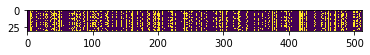

In [124]:
brief = rBRIEF(square, points, orientations, BRIEF_PAIRS)
plt.imshow(brief)
plt.show()

# ORB

In [129]:
@njit
def ORB(img, npoints = 256, threshold = 0.3):
    points, orientations = oFast(img, n = npoints, threshold = threshold)
    smoothed = create_smoothed(create_integral(img))
    brief = rBRIEF(smoothed, points, orientations, BRIEF_PAIRS)
    return brief, points

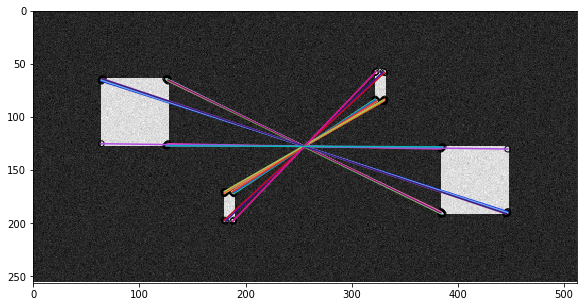

In [130]:
descriptors1, keypoints1 = ORB(square1, npoints = 32, threshold = 0.2)
descriptors2, keypoints2 = ORB(square2, npoints = 32, threshold = 0.2)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
fig, ax = plt.subplots(figsize = (10,5))
plot_matches(ax, square1, square2, keypoints1, keypoints2, matches12)
plt.show()

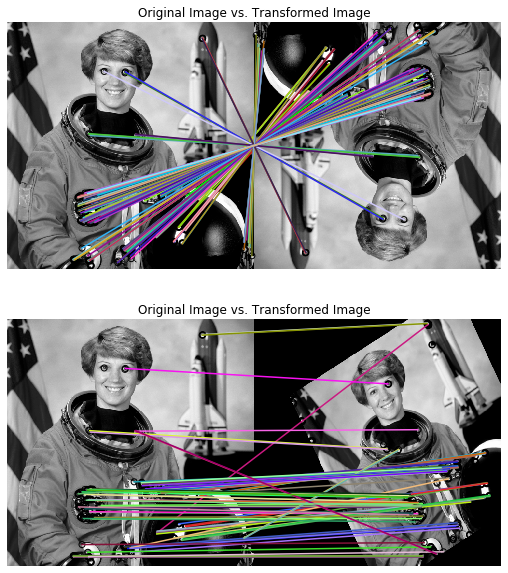

In [136]:
descriptors1, keypoints1 = ORB(img1, npoints = 256)
descriptors2, keypoints2 = ORB(img2, npoints = 256)
descriptors3, keypoints3 = ORB(img3, npoints = 256)

matches12 = match_descriptors(descriptors1, descriptors2)#, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3)#, cross_check=True)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
plt.gray()

plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
ax[0].axis('off')
ax[0].set_title("Original Image vs. Transformed Image")

plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
ax[1].axis('off')
ax[1].set_title("Original Image vs. Transformed Image")

plt.show()